# Промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. 

Цель проекта:

- построить модель, которая предскажет температуру стали.

## Описание этапа обработки - технологического процесса

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

## Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` — данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## Импорт необходимых библиотек

In [1]:
# pip install lightgbm; # устанавливаем, если необходимо библиотеку

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import lightgbm as lgb 

In [3]:
from sklearn import linear_model

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.dummy import DummyRegressor #импорт "глупого" классификатора, для создания baseline модели
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression #импорт модуля линейной регрессии
from sklearn.metrics import mean_absolute_error #импорт метрики среднего абсолютного значения
from sklearn.preprocessing import StandardScaler #метод масштабирования по стандартным отклонениям
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle

from pandas import option_context

from statsmodels.stats.outliers_influence import variance_inflation_factor  
from statsmodels.tools.tools import add_constant 


In [4]:
import warnings
warnings.filterwarnings('ignore')

## Подготовка констант

In [5]:
RANDOM_STATE = 100423

## Знакомство с данными

### Данные об электродах

In [6]:
try:
    data_arc = pd.read_csv(r'E:\Practicum\2_Projects_Git\14_manufactory\data_arc.csv')
except:
    data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')

In [7]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [8]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Таблица содержит 5 столбцов (в т.ч. `key`) и 14876 строк. Не имеет пустых ячеек. Данные о времени имеют тип `object`, что требует корректировки на этапе предобработки данных.

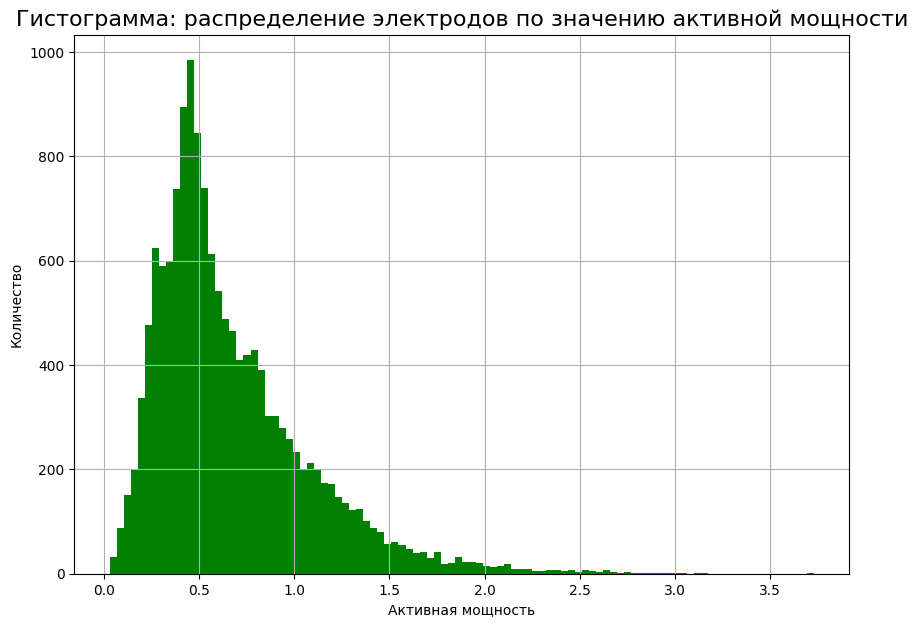

In [9]:
#строим гистограмму для столбца с возрастом
fig, ax = plt.subplots() #добавить действия для работы над фигурой и осями из библиотеки
ax.set_xlabel('Активная мощность') #подпись оси х
ax.set_ylabel('Количество') #подпись оси y

(
    data_arc['Активная мощность'] #столбец с данными
    .hist(bins=100, figsize=(10, 7), color='green', grid=True) #гистограмма определенного размера, цвета и количества корзин
    .set_title('Гистограмма: распределение электродов по значению активной мощности', fontsize = 16, color = 'Black') #название гистограммы и его оформление
);

In [10]:
display(data_arc['Активная мощность'].describe()); #описание данных

count    14876.000000
mean         0.670441
std          0.408159
min          0.030002
25%          0.395297
50%          0.555517
75%          0.857034
max          3.731596
Name: Активная мощность, dtype: float64

Имеется длинный хвост справа, возможно, будем работать с ними, как с выбросами.

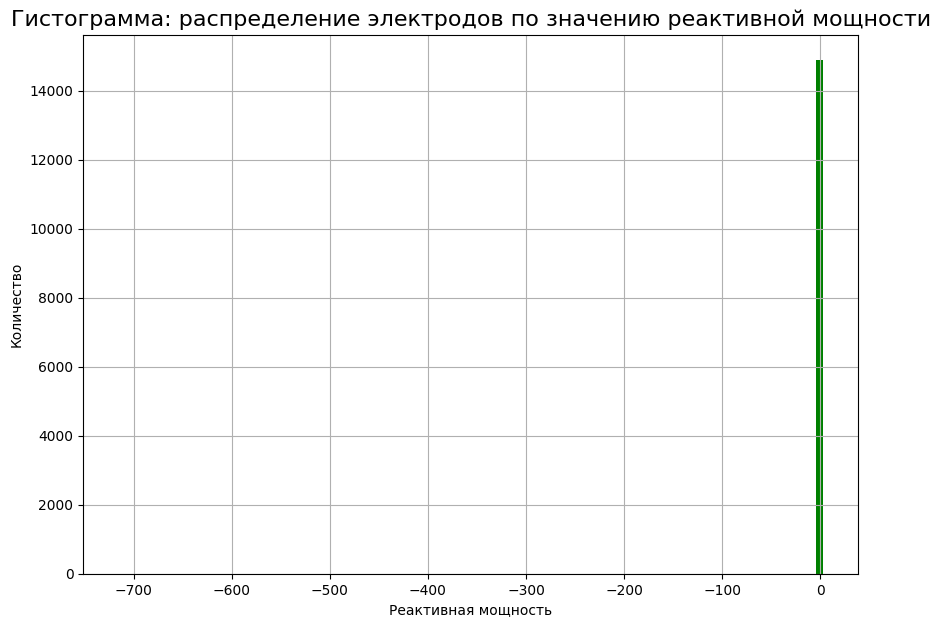

In [11]:
#строим гистограмму для столбца с возрастом
fig, ax = plt.subplots() #добавить действия для работы над фигурой и осями из библиотеки
ax.set_xlabel('Реактивная мощность') #подпись оси х
ax.set_ylabel('Количество') #подпись оси y

(
    data_arc['Реактивная мощность'] #столбец с данными
    .hist(bins=100, figsize=(10, 7), color='green', grid=True) #гистограмма определенного размера, цвета и количества корзин
    .set_title('Гистограмма: распределение электродов по значению реактивной мощности', fontsize = 16, color = 'Black') #название гистограммы и его оформление
);

В столбце "Реактивной мощности" встречаются выбросы слева, в пределах значения -700. Такой мощности быть не может, поэтому от таких значений нужно будет избавиться.

In [12]:
display(data_arc['Реактивная мощность'].describe()); #описание данных

count    14876.000000
mean         0.452592
std          5.878702
min       -715.504924
25%          0.290991
50%          0.415962
75%          0.637371
max          2.676388
Name: Реактивная мощность, dtype: float64

Посмотрим на корреляцию между мощностями на непредобработанных данных. При просмотре первых пяти строк датасета мы видим четкую зависимость: 

- реактивная мощность обычно меньше активной;
- чем выше активная, тем выше реактивная мощность.

На непредобработанных данных не будет такой четкой картины, но оценить корреляцию стоит уже сейчас.

0.05443724339693738

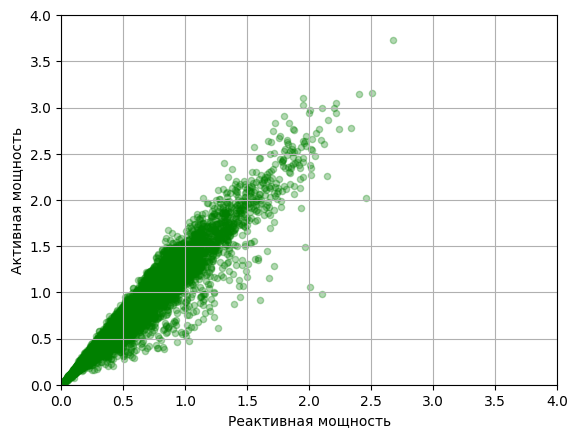

In [13]:
display(data_arc['Реактивная мощность'].corr(data_arc['Активная мощность'])) #отобразить корреляцию

ax = data_arc.plot(x='Реактивная мощность', y='Активная мощность', #по фильтру, по х - мировые продажи, по у - оценки пользователей
          kind='scatter', sharex=False, grid=True, xlim=(0,4), ylim=(0,4), #вид - диаг. рассеяния, сетка, пределы по осям
          alpha=0.3, c='g') #прозрачность, цвет

Полная мощность - это квадратный корень из суммы квадратов реактивной (не несущей полезного эффекта) и активной (полезной) мощности. Таким образом, можем вычислить значение полной мощности или/и КПД системы, что может являться новыми признаками.

Также, имеем данные времени нагрева. С помощью них мы сможем посчитать суммарное время, затраченное на нагрев при средней полной мощности и КПД.

#### Краткий вывод

Данные для электродов описаны. Имеются несовпадения типа данных, которые нужно будет привести к нужному виду. Также имеюся выбросы с которыми нужно бует поработать.

### Данные о подаче сыпучих материалов (объём)

In [14]:
try:
    data_bulk = pd.read_csv(r'E:\Practicum\2_Projects_Git\14_manufactory\data_bulk.csv')
except:
    data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')

In [15]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [16]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Датасет с информацией о подаче объема сыпучих материалов содержит огромное количество пустых ячеек во всех столбцах. Где-то заполнено до 80-85% данных, где-то только одно значение из 3129 строк. 

Датасет содержит, как указал ранее, 3129 строк, а также 16 столбцов (здесь и далее буду писать количество столбцов всегда с учетом столбца `key`). Данные распределены неравномерно. Также мы не знаем, какие вещества (или группы веществ) зашифрованы в названиях столбцов.

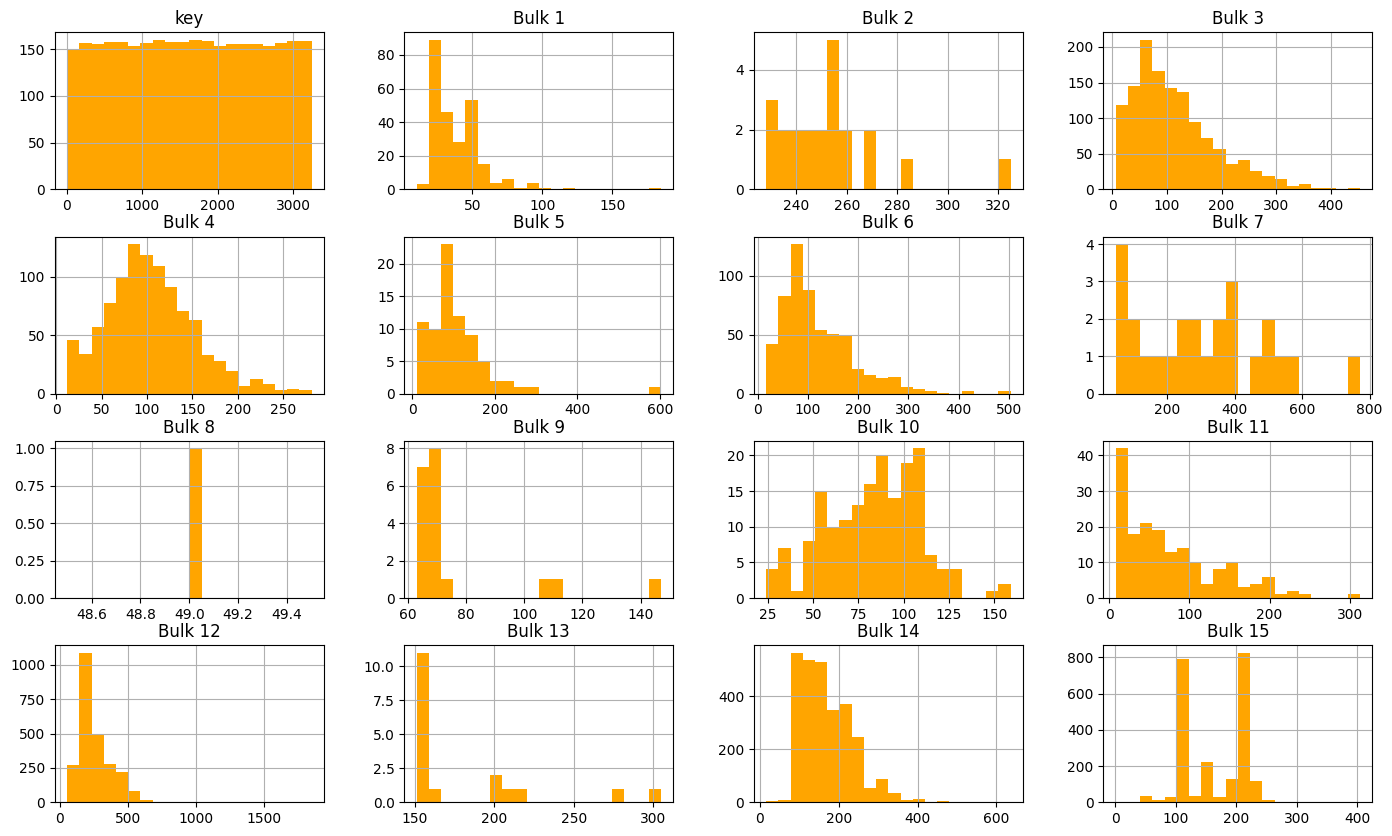

In [17]:
(
    data_bulk #данные
    .hist(bins=20, figsize=(17, 10), color='orange', grid=True) #гистограмма определенного размера, цвета и количества корзин
);

Что-либо "вытащить" из этих данных на данном этапе не представляеся возможным.

Посмотрим на объемы каждого сыпучего компонента.

In [18]:
data_bulk_volume = data_bulk.drop(columns='key').sum().sort_values(ascending= False).to_frame() #суммируем и сортируем по объему
data_bulk_quant = data_bulk.drop(columns='key').count().sort_values(ascending= False).to_frame() #считаем количество добавлений
data_bulk_f = pd.merge(data_bulk_volume, data_bulk_quant, left_index=True, right_index=True) #соединяем таблицы
data_bulk_f.rename(columns = {'0_x':'Объем', '0_y': 'Количество добавлений'}, inplace = True ) #переименовываем
data_bulk_f

,Объем,Количество добавлений
Bulk 12,638154.0,2450
Bulk 14,477819.0,2806
Bulk 15,360834.0,2248
Bulk 3,147815.0,1298
Bulk 4,105856.0,1014
Bulk 6,68501.0,576
Bulk 10,14658.0,176
Bulk 11,13597.0,177
Bulk 1,9889.0,252
Bulk 5,8241.0,77


Постоим столбчатую диаграмму распределения объемов и количества засыпаний для каждого компонента. 

- фиолетовый градиент - это значение с количеством раз, когда добавку осуществляли, 
- зеленый градиент - это общий объем добавок.

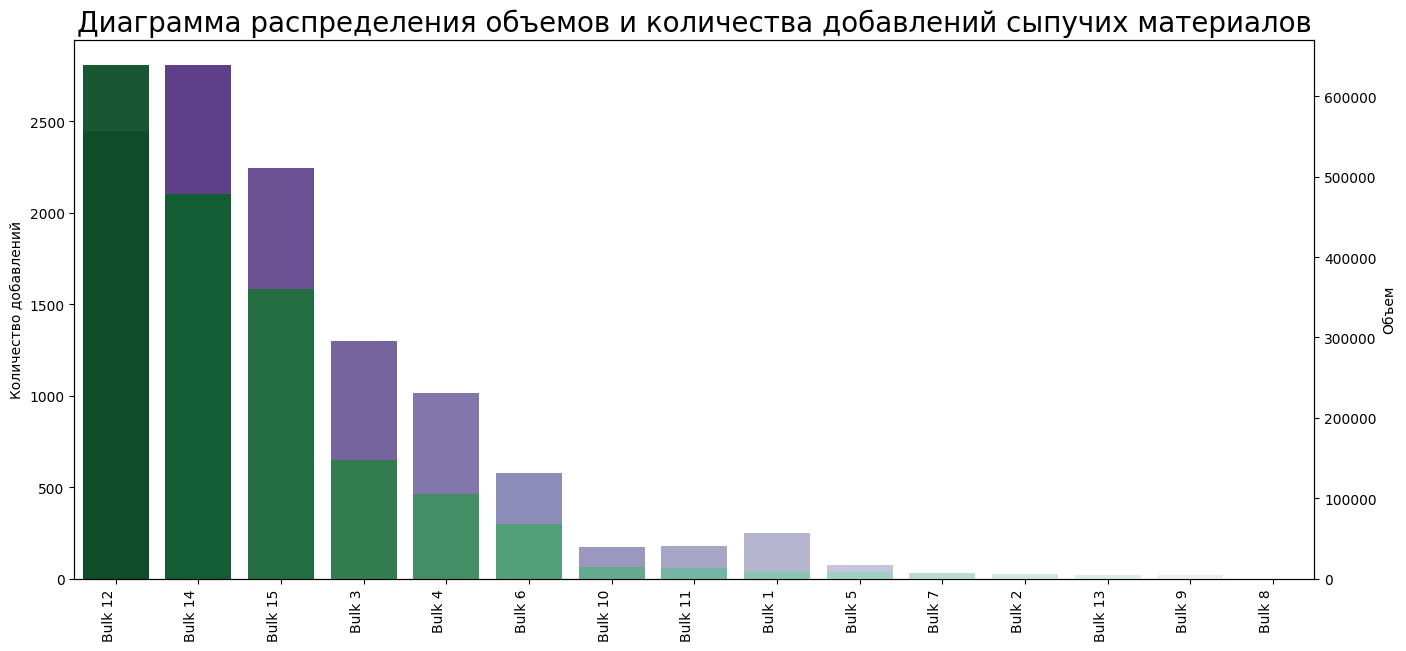

In [19]:
fig, ax = plt.subplots(figsize=(16, 7)) # задаем размер
ax2 =ax.twinx()

# строим столбчатую гистограмму по столбу с объемом, зеленого градиента
sns.barplot(
    x=data_bulk_f.index, 
    y=data_bulk_f.iloc[:, 0], 
    alpha=0.95,
    palette=sns.color_palette("BuGn_r", n_colors=len(data_bulk_f)), 
    ax=ax2)
    
# строим столбчатую гистограмму по столбу с количеством , фиолетового градиента
sns.barplot(
    x=data_bulk_f.index, 
    y=data_bulk_f.iloc[:, 1], 
    alpha=0.95,
    palette=sns.color_palette("Purples_r", n_colors=len(data_bulk_f)), 
    ax=ax).set_title(
        'Диаграмма распределения объемов и количества добавлений сыпучих материалов',
        fontsize = 20,
        color = 'Black')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
plt.show()

Из диаграммы видно, что добавки Bulk 1, 2, 5, 7, 8, 9, 10, 11 и 13 имеют очень малый объем в общем количестве примесей.

#### Краткий вывод

В данных о подаче по объему содержится много столбцов, много пропусков и как-либо интерпретировать полученные данные на данном этапе не представляется возможным. Ничего нельзя сказать и про выбросы. Зато с типом данных проблем нет: все данные - вещественные значения.

Был произведен анализ сыпучих материалов, найдено и показано их распределение в процессе плавления.

### Данные о подаче сыпучих материалов (время)

In [20]:
try:
    data_bulk_time = pd.read_csv(r'E:\Practicum\2_Projects_Git\14_manufactory\data_bulk_time.csv')
except:
    data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')

In [21]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [22]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


#### Краткие выводы

Имеем полное совпадение по количеству пропусков, что и в таблице объемов. Думаю, что эта таблица - копия предыдущей, только данные другие - время.

Тип данных требует корректировки и приведения его вида ко времени.

### Данные о продувке сплава газом

In [23]:
try:
    data_gas = pd.read_csv(r'E:\Practicum\2_Projects_Git\14_manufactory\data_gas.csv')
except:
    data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')

In [24]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [25]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


Датасет содержит только ключ и столбец с данными о газе (возможно, объем). Пропусков нет, количество строк 3239.

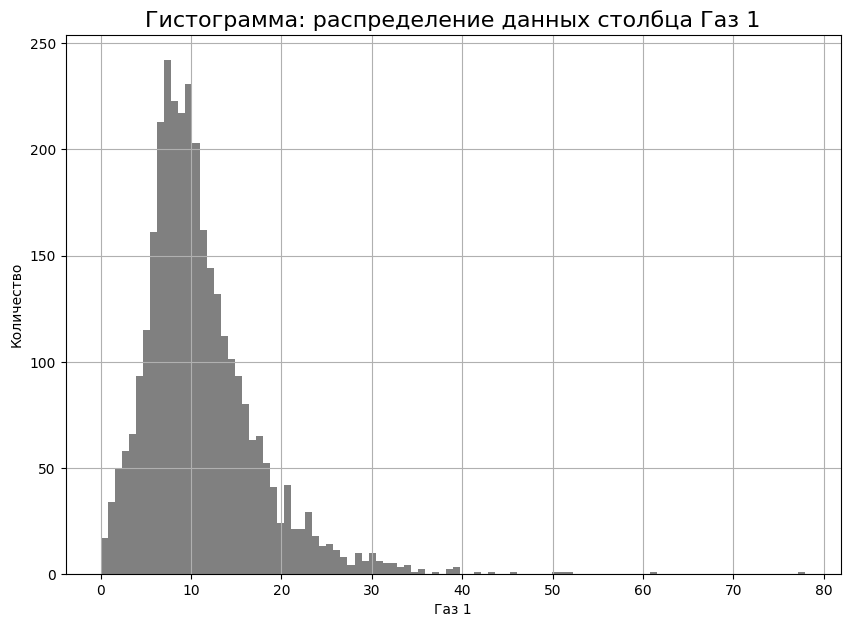

In [26]:
#строим гистограмму для столбца с возрастом
fig, ax = plt.subplots() #добавить действия для работы над фигурой и осями из библиотеки
ax.set_xlabel('Газ 1') #подпись оси х
ax.set_ylabel('Количество') #подпись оси y

(
    data_gas['Газ 1'] #столбец с данными
    .hist(bins=100, figsize=(10, 7), color='grey', grid=True) #гистограмма определенного размера, цвета и количества корзин
    .set_title('Гистограмма: распределение данных столбца Газ 1', fontsize = 16, color = 'Black') #название гистограммы и его оформление
);

In [27]:
data_gas['Газ 1'].describe()

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: Газ 1, dtype: float64

#### Краткие выводы

Датасет не имеет пропусков и проблем с типом файла. Согласно построенной гистограмме, датасет все же имеет хвост справа - выбросы, с которыми нужно будет поработать.

### Результаты измерения температуры

In [28]:
try:
    data_temp = pd.read_csv(r'E:\Practicum\2_Projects_Git\14_manufactory\data_temp.csv')
except:
    data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')

In [29]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


Данный датасет содержит целевой признак для будующей модели - температуру стали. 

In [30]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


Имеем пропуски в целевом признаке (возможно это те данные, что мы будем предсказывать). Датасет содержит 15907 строк и 3 столбца. Тип данных для времени указан неверно. 

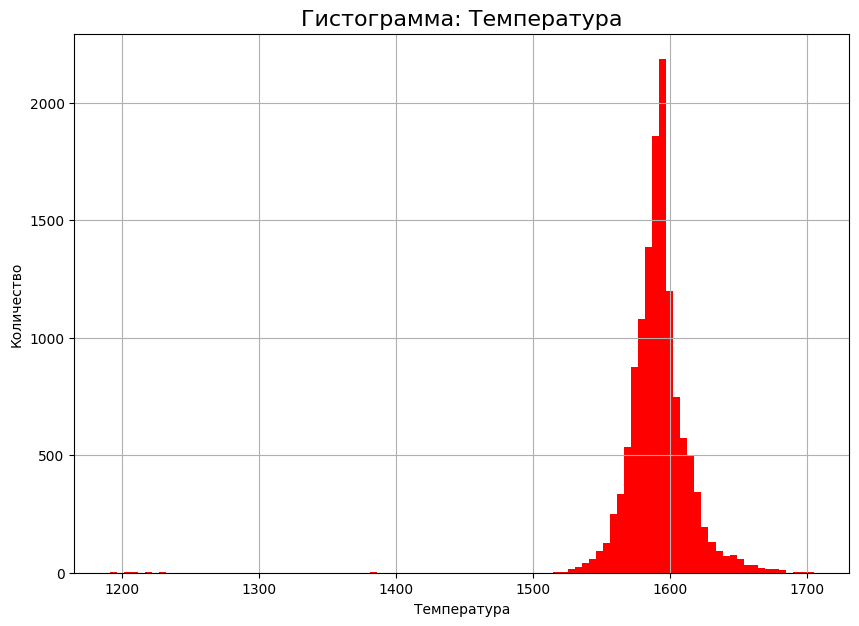

In [31]:
#строим гистограмму для столбца с возрастом
fig, ax = plt.subplots() #добавить действия для работы над фигурой и осями из библиотеки
ax.set_xlabel('Температура') #подпись оси х
ax.set_ylabel('Количество') #подпись оси y

(
    data_temp['Температура'] #столбец с данными
    .hist(bins=100, figsize=(10, 7), color='red', grid=True) #гистограмма определенного размера, цвета и количества корзин
    .set_title('Гистограмма: Температура', fontsize = 16, color = 'Black') #название гистограммы и его оформление
);

In [32]:
data_temp['Температура'].describe()

count    13006.000000
mean      1591.840920
std         21.375851
min       1191.000000
25%       1581.000000
50%       1591.000000
75%       1601.000000
max       1705.000000
Name: Температура, dtype: float64

#### Краткие выводы

Согласно описанию столбца температур, мы имеем очень точное совпадение по среднему и медианному значению, следвательно хвост слева - это, действительно, единичные случаи температуры, не вписывающейся в нормальное распределение (судя по гистограмме), а следовательно, точно являются выбросами.

Дополнительно к этому, одно из условий ТЗ - температуры менее 1500 являются выбросами. Такие данные нужно будет убрать.

In [33]:
try:
    data_wire = pd.read_csv(r'E:\Practicum\2_Projects_Git\14_manufactory\data_wire.csv')
except:
    data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')

### Данные о проволочных материалах (объём)

In [34]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [36]:
data_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


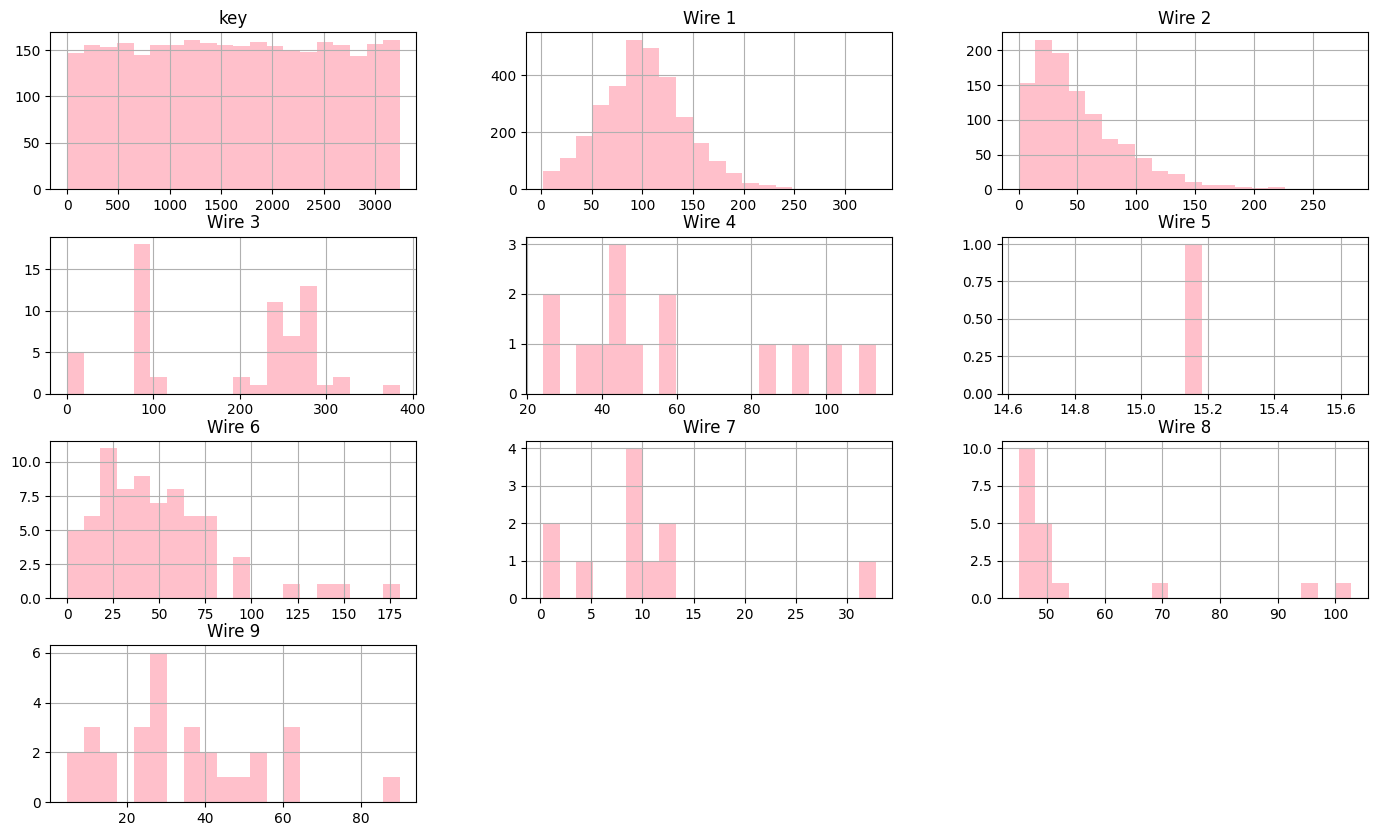

In [37]:
(
    data_wire #данные
    .hist(bins=20, figsize=(17, 10), color='pink', grid=True) #гистограмма определенного размера, цвета и количества корзин
);

Найдем объемы добавляемых в сплав проволок.

In [38]:
data_wire_volume = data_wire.drop(columns='key').sum().sort_values(ascending= False).to_frame() #суммируем и сортируем по объему
data_wire_quant = data_wire.drop(columns='key').count().sort_values(ascending= False).to_frame() #считаем количество добавлений
data_wire_f = pd.merge(data_wire_volume, data_wire_quant, left_index=True, right_index=True) #соединяем таблицы
data_wire_f.rename(columns = {'0_x':'Объем', '0_y': 'Количество добавлений'}, inplace = True ) #переименовываем
data_wire_f

,Объем,Количество добавлений
Wire 1,308236.830606,3055
Wire 2,54572.931650,1079
Wire 3,11937.408916,63
Wire 6,3505.239099,73
Wire 8,1018.878666,19
Wire 9,990.516814,29
Wire 4,804.199781,14
Wire 7,110.429080,11
Wire 5,15.132000,1


Постоим столбчатую диаграмму распределения объемов и количества добавлений для каждого компонента. 

- синий градиент - это значение с количеством раз, когда добавку проволоки осуществляли, 
- розовый градиент - это общий объем добавок.

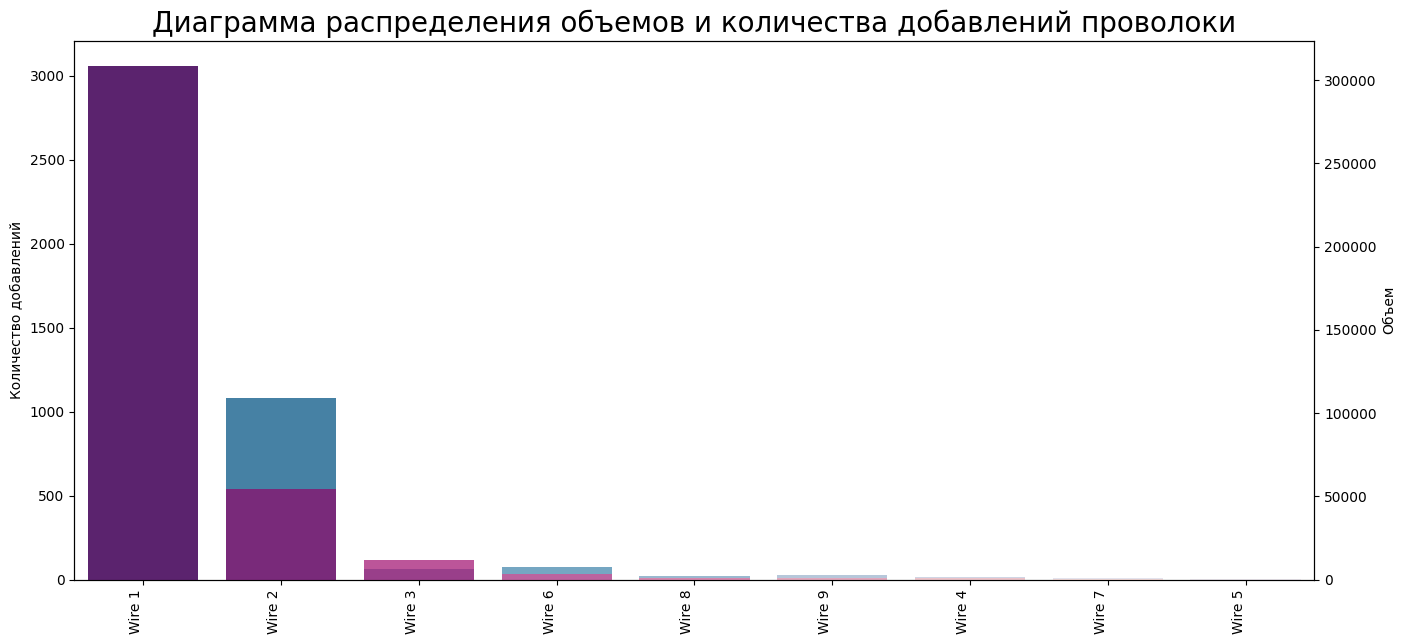

In [39]:
fig, ax = plt.subplots(figsize=(16, 7)) # задаем размер
ax2 =ax.twinx()

# строим столбчатую гистограмму по столбу с объемом, розового градиента
sns.barplot(
    x=data_wire_f.index, 
    y=data_wire_f.iloc[:, 0], 
    alpha=0.8,
    palette=sns.color_palette("RdPu_r", n_colors=len(data_wire_f)), 
    ax=ax2)
    
# строим столбчатую гистограмму по столбу с количеством , синего градиента
sns.barplot(
    x=data_wire_f.index, 
    y=data_wire_f.iloc[:, 1], 
    alpha=0.8,
    palette=sns.color_palette("PuBu_r", n_colors=len(data_wire_f)), 
    ax=ax).set_title(
        'Диаграмма распределения объемов и количества добавлений проволоки',
        fontsize = 20,
        color = 'Black')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
plt.show()

Из диаграммы видно, что все проволоки, кроме Wire 1 и Wire 2 - очень незачительны по объему.

### Данные о проволочных материалах (время)

In [40]:
try:
    data_wire_time = pd.read_csv(r'E:\Practicum\2_Projects_Git\14_manufactory\data_wire_time.csv')
except:
    data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

In [41]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


#### Краткий вывод

В последних двух датасетах наблюдаем похожую картину: есть какой-то набор проводов. Не все добавлены, и соответственно, имеется много пропусков. Там, где провод есть - есть и значение времени. Все как и в датасетах сыпучих материалов, только другие значения и размеры сетов. Там, где данных нет - не использовали провод, следовательно, будем принимать нулевое значение.

## План

После ознакомления с данными, имеется такой план дейтвий:

Предобработка данных:

1. В `data_arc`:

- Убрать выбросы отрицательной мощности (по ключу `key`, здесь и далее),
- Создать столбец полной мощности,
- Создать столбец КПД,
- Перевести дату в нужный тип и посчитать временные интервалы с секундах.

2. В `data_bulk`:

- так как поля со значениями `NaN` значат то, что никакие сыпучие материалы не добавлялись, то пропуски заполняем нулями,

3. В `data_bulk_time`:

- Учитывая, что пока значение времени сложно оценить в расчете модели, возможным действием с этими значениями может быть: зная время начала нагрева из `data_arc` для первой итерации, можно посчитать разницу между значением времени в `data_arc` и значением времени в `data_bulk_time` в секундах (изменить тип). Если это негативно скажется на будущих моделях, имеет смысл исключить датасет из данных,
- `NaN` заполнить нулями. 

4. В `data_gas`:

- Датасет готов к работе.

5. В `data_temp`:

- В этом датасете есть целевой признак - температура. На этапе предобработки нужно убрать данные о температуре (по ключу), в которых встречаются значения температуры менее 1500 градусов,
- также, по ключу, убираем данные, где нет конечного значения температуры для ключа. Промежуточные значения температур не используются для признаков. Начальное значение температуры можно принять признаком, а конечное значение - таргетом.

6. В `data_wire`:

- Аналогично п. 2.

7. В `data_wire_time`:

- Аналогично п. 3.


Важно учитывать, что выбросы по температуре и отрицательной мощности мы убираем со всего датасета. Остальные выбросы (если мы их будем таковыми рассматривать), только с тренировочных данных. В тестовую выборку должны попасть честные данные.

Перед началом обучения и после предобработки все таблицы мы объединяем по ключу и агрегируем тоже по ключу. Разбиваем данные в соотношении 75% (`train`) к 25% (`test`) и с значением `random_state` = 110423.

После этого, мы можем также убрать все оставшиеся выбросы из `train`, если это необходимо.

Данные можно стандартизировать (т.к. на деревянные модели это не влияет, зато это нужно для линейных моделей).

Используем несколько моделей для обучения (в том числе дамми модель средней температуры, чтобы было с чем сравнивать) с перебором гиперпараметров и обязательной кросс-валидацией (можно также использовать `pipeline` и другие конструкты).

Метрикой качества в проекте выступает `MAE`. Мае должна быть менее 6.8 (удовлетворительно; 6.3 - хорошо; 6 и ниже - отлично).

Лучшая модель с лучшими гиперпараметрами, которая покажет оценку не хуже требуемой - будет являться конечной целью проекта.

В конце будут написаны выводы по проделанной работе.

На данном этапе вопросов нет

## Предобработка данных

### `data_arc`

In [279]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


Найдем отрицательные значения для реактивной мощности.

In [280]:
data_arc.loc[data_arc.loc[:, 'Реактивная мощность'] < 0] #фильтр реактивной мощности меньше нуля

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


Это всего одно значение с ключом 2116. Просмотрим все строки с этим ключом.

In [281]:
data_arc.loc[data_arc.loc[:, 'key'] == 2116] #поиск - фильтр по ключу

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9778,2116,2019-07-24 00:29:52,2019-07-24 00:31:54,0.433266,0.306141
9779,2116,2019-07-24 00:35:50,2019-07-24 00:38:05,0.620265,0.408352
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924
9781,2116,2019-07-24 00:51:51,2019-07-24 00:52:58,0.299368,0.198796


Действительно, такие значения мощности вызывают вопросы, поэтому мы должны убрать все данные с этим ключом.

In [282]:
# фильтр с перезаписью данных. остаются значения не равные выбранном key. перезапись индексов
data_arc = data_arc.loc[data_arc.loc[:, 'key'] != 2116].reset_index(drop= True)

Так как таблицы будут объединяться по ключу `key` у нас не будет проблем со смещением данных после удаления строк.

Посчитаем полную мощность и КПД и добавим эти значения в столбцы справа.

In [283]:
# полная мощность - теорема Пифагора
data_arc['Полная мощность'] = (data_arc['Активная мощность']**2 + data_arc['Реактивная мощность']**2)**0.5

# значение КПД
data_arc['КПД'] = data_arc['Активная мощность'] / data_arc['Полная мощность']

In [284]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность,КПД
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639,0.817717
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010,0.840041
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038,0.830728
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470,0.842115
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239,0.858178


Добавляем столбец с длительностью. Для этого меняем тип даты для столбцов со временем.

In [285]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой']) # меняем тип на дату
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])

In [286]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14872 entries, 0 to 14871
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14872 non-null  int64         
 1   Начало нагрева дугой  14872 non-null  datetime64[ns]
 2   Конец нагрева дугой   14872 non-null  datetime64[ns]
 3   Активная мощность     14872 non-null  float64       
 4   Реактивная мощность   14872 non-null  float64       
 5   Полная мощность       14872 non-null  float64       
 6   КПД                   14872 non-null  float64       
dtypes: datetime64[ns](2), float64(4), int64(1)
memory usage: 813.4 KB


Добавим столбец с дельтой времени - из конечного времени каждой записи (пока не объединяем ключи) вычитаем начальное время и переводим данные в секунды.

In [287]:
# вычисляем длительность как разность конечного и начального времени. переводим в секунды.
data_arc['Длительность'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']).astype('timedelta64[s]')

КПД и полная мощность для признаков достаточны и более показательны, можем убирать активную и реактивную мощность, так как они будут излишними. Также, убираем конечное время. Больше эти данные не нужны. Начальное время оставим для его сравнения с другими датами в следующих таблицах.

In [288]:
# удаляем лишние данные
data_arc.drop(columns= ['Активная мощность', 'Реактивная мощность', 'Конец нагрева дугой'], inplace= True)

In [289]:
data_arc.head(7)

,key,Начало нагрева дугой,Полная мощность,КПД,Длительность
0,1,2019-05-03 11:02:14,1.193639,0.817717,228.0
1,1,2019-05-03 11:07:28,0.959010,0.840041,185.0
2,1,2019-05-03 11:11:44,0.896038,0.830728,172.0
3,1,2019-05-03 11:18:14,1.970470,0.842115,365.0
4,1,2019-05-03 11:26:09,0.807239,0.858178,148.0
5,2,2019-05-03 11:34:14,0.521549,0.839928,137.0
6,2,2019-05-03 11:38:50,1.574162,0.823559,338.0


Выделим начальное время для каждого ключа.

In [290]:
first_time = data_arc.groupby('key')['Начало нагрева дугой'].first().to_frame() #группируем данные по времени первого нагрева и преобразуем в датасет
data_arc.drop(columns= ['Начало нагрева дугой'], inplace= True) #удаляем лишний столбец
first_time.rename(columns = {'Начало нагрева дугой':'Старт'}, inplace = True ) # переименовываем столбец
data_arc = data_arc.merge(first_time, on='key') #склеиваем таблицы по ключу key

In [291]:
data_arc.head(7)

,key,Полная мощность,КПД,Длительность,Старт
0,1,1.193639,0.817717,228.0,2019-05-03 11:02:14
1,1,0.959010,0.840041,185.0,2019-05-03 11:02:14
2,1,0.896038,0.830728,172.0,2019-05-03 11:02:14
3,1,1.970470,0.842115,365.0,2019-05-03 11:02:14
4,1,0.807239,0.858178,148.0,2019-05-03 11:02:14
5,2,0.521549,0.839928,137.0,2019-05-03 11:34:14
6,2,1.574162,0.823559,338.0,2019-05-03 11:34:14


Для полной мощности и КПД агрегация должна быть по среднему значению (т.к. подаваемая мощность не суммируется, она распределена по времени), а значение Длительности, напротив, мы должны просуммировать.

In [292]:
mean_values = data_arc.groupby('key')[['Полная мощность', 'КПД']].mean() #группируем данные по времени первого нагрева и преобразуем в датасет
data_arc.drop(columns= ['Полная мощность', 'КПД'], inplace= True) #удаляем лишний столбец
data_arc = data_arc.merge(mean_values, on='key') #склеиваем таблицы по ключу key

In [293]:
sum_duration = data_arc.groupby('key')['Длительность'].sum().to_frame() #суммируем время с группировкой по ключу
data_arc.drop(columns= ['Длительность'], inplace= True) #удаляем лишний столбец
data_arc = data_arc.merge(sum_duration, on='key') #склеиваем таблицы по ключу key

И группируем каждый этап.

In [294]:
data_arc = data_arc.groupby('key').first() #группируем данные по температуре первого замера и преобразуем в датасет
data_arc.head()

,Старт,Полная мощность,КПД,Длительность
key,,,,
1,2019-05-03 11:02:14,1.165279,0.837756,1098.0
2,2019-05-03 11:34:14,0.912304,0.840158,811.0
3,2019-05-03 12:06:54,0.597907,0.845421,655.0
4,2019-05-03 12:39:37,0.953741,0.841682,741.0
5,2019-05-03 13:11:13,1.008939,0.828104,869.0


In [295]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3213 entries, 1 to 3241
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Старт            3213 non-null   datetime64[ns]
 1   Полная мощность  3213 non-null   float64       
 2   КПД              3213 non-null   float64       
 3   Длительность     3213 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 125.5 KB


Мы подготовили датасет, убрали выбросы, создали признаки, поработали с типом данных.

### `data_bulk`

В датасете имеется огромное количество пропусков - это тоже данные. Каждый пропуск - это не засыпанный в сплав сыпучий материал. Заполним пропуски нулевыми значениями.

In [296]:
data_bulk.fillna(0, inplace= True) # заполняем пропуски

### `data_bulk_time`

Датасет содержит данные о времени загрузки сыпучих материалов. Для того, чтобы извлечь признаки из этих данных, нужно преобразовать тип ко времени. На этапе присоединения датасетов мы сможем найти дельту времени от начального времени, тем самым получив признаки.

Пропущенные данные будут обработаны позднее.

В процессе обучения мы сможем проверить, не мешает ли этот датасет обучению.

In [297]:
bulk_list = [column for column in data_bulk_time.drop(columns= 'key')] #собираем список названий столбцов

#собираем цикл для перебора названий столбцов и смены типа данных
for bulk in bulk_list: 
    data_bulk_time[bulk] = pd.to_datetime(data_bulk_time[bulk])

In [298]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


### `data_gas`

Ранее уже говорилось, что этот датасет готов к работе. Те выбросы, которые имеются в данных мы сможем убрать только после деления на выборки, и только из тренировочных данных, если это будет необходимо.

### `data_temp`

Для того, чтобы можно было работать со значениями `NaN` как с числами, сделаем заглушку. Например, значение = -100.

In [299]:
data_temp.fillna(-100, inplace= True) # ставим заглушки - значения, которых точно нет в датасете.

Первое, что необходимо сделать - удалить ключи, в данных которых есть пропуски (а теперь заглушки со значением = -100) у первого и последнего значения ключа.

Проверим первые значения в группах:

In [300]:
data_temp.groupby('key')['Температура'].first().min() #находим минимальное первое в группе ключа key значение температуры

1191.0

В первых значениях не было пропусков. Проверяем последние значения:

In [301]:
data_temp.groupby('key')['Температура'].last().min() #находим минимальное последнее в группе ключа key значение температуры

-100.0

Находим ключи данных, для которых было пустым последнее значение:

In [302]:
data_temp_last = data_temp.groupby('key')['Температура'].last().to_frame() #преобразовываем в датафрейм данные с последними значениями в группах
data_temp_nan = data_temp_last.loc[data_temp_last.loc[:, 'Температура'] == -100] # находим только значения, в которых стоят заглушки
list_to_drop = list(data_temp_nan.index) #список ключей для удаления из датасета data_temp

In [303]:
data_temp = data_temp.query('key not in @list_to_drop') #оставляем значение НЕ входящие в список удаления.

Теперь, подобную операцию проводи с ключами, среди температур которых имеются значения менее 1500 градусов.

In [304]:
below500 = data_temp.loc[data_temp.loc[:, 'Температура'] < 1500]
below500

,key,Время замера,Температура
4350,867,2019-06-04 14:21:00,1191.0
5978,1214,2019-06-16 05:32:00,1208.0
7958,1619,2019-06-30 11:03:54,1218.0
8913,1818,2019-07-07 00:30:49,1383.0
8914,1818,2019-07-07 00:31:40,1383.0
10127,2052,2019-07-21 14:51:40,1227.0


Всего шесть значений ключей. Соберем их в список и удалим эти данные из датасета.

In [305]:
list_below500 = list(below500['key'])
data_temp = data_temp.query('key not in @list_below500').reset_index(drop= True)

Преобразуем дату в `datetype`.

In [306]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера']) # меняем тип на дату

Здесь можно выделить дату и время первого замера и последнего замеров, а также температуру первого замера в отдельные столбцы. с их помощью мы сделаем новые признаки опираясь на дату в таблице `data_arc`.

In [307]:
first_time_meash = data_temp.groupby('key')['Время замера'].first().to_frame() #группируем данные по времени первого замера температуры и преобразуем в датасет
first_time_meash.rename(columns = {'Время замера':'Время первого замера'}, inplace = True ) # переименовываем столбец

last_time_meash = data_temp.groupby('key')['Время замера'].last().to_frame() #группируем данные по времени последнего замера температуры и преобразуем в датасет
last_time_meash.rename(columns = {'Время замера':'Время последнего замера'}, inplace = True )

In [308]:
data_temp = data_temp.merge(first_time_meash, on='key') #склеиваем таблицы по ключу key
data_temp = data_temp.merge(last_time_meash, on='key')
data_temp.drop(columns= ['Время замера'], inplace= True) #удаляем лишний столбец времени

In [309]:
data_temp.head(7)

,key,Температура,Время первого замера,Время последнего замера
0,1,1571.0,2019-05-03 11:16:18,2019-05-03 11:30:39
1,1,1604.0,2019-05-03 11:16:18,2019-05-03 11:30:39
2,1,1618.0,2019-05-03 11:16:18,2019-05-03 11:30:39
3,1,1601.0,2019-05-03 11:16:18,2019-05-03 11:30:39
4,1,1613.0,2019-05-03 11:16:18,2019-05-03 11:30:39
5,2,1581.0,2019-05-03 11:37:27,2019-05-03 11:59:12
6,2,1577.0,2019-05-03 11:37:27,2019-05-03 11:59:12


Мы сделали два новых столбца, но признаками они станут после присоединения к таблице `data_arc`, т.к. она содержит начальное время, от которого будут зависить признаки (признаки - это разница во времени между стартом и этапом).

Промежуточные значения температур не будут использоваться в работе. Первые значения температур - это признак, конечные значения температур - целевой признак. Разделим эти значения.

In [310]:
first_temp_meash = data_temp.groupby('key')['Температура'].first().to_frame() #группируем данные по температуре первого замера и преобразуем в датасет
first_temp_meash.rename(columns = {'Температура':'Температура первого замера'}, inplace = True ) # переименовываем столбец

last_temp_meash = data_temp.groupby('key')['Температура'].last().to_frame() #группируем данные по температуре последнего замера и преобразуем в датасет
last_temp_meash.rename(columns = {'Температура':'Температура целевая'}, inplace = True )

In [311]:
data_temp = data_temp.merge(first_temp_meash, on='key') #склеиваем таблицы по ключу key
data_temp = data_temp.merge(last_temp_meash, on='key')
data_temp.drop(columns= ['Температура'], inplace= True) #удаляем лишний столбец времени

In [312]:
data_temp.head(7)

,key,Время первого замера,Время последнего замера,Температура первого замера,Температура целевая
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0
1,1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0
2,1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0
3,1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0
4,1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0
5,2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0
6,2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0


Группируем по ключу. Таблица подготовлена.

In [313]:
data_temp = data_temp.groupby('key').first() #группируем данные по температуре первого замера и преобразуем в датасет
data_temp.head()

,Время первого замера,Время последнего замера,Температура первого замера,Температура целевая
key,,,,
1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0
2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0
3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0
4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0
5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0


In [314]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2472 entries, 1 to 2499
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Время первого замера        2472 non-null   datetime64[ns]
 1   Время последнего замера     2472 non-null   datetime64[ns]
 2   Температура первого замера  2472 non-null   float64       
 3   Температура целевая         2472 non-null   float64       
dtypes: datetime64[ns](2), float64(2)
memory usage: 96.6 KB


### `data_wire`

Аналогично пропускам в `data_bulk`, здесь пропуски играют важное значение: недобавленная в сплав проволока. Заполняем нулями.

In [315]:
data_wire.fillna(0, inplace= True) # заполняем пропуски

### `data_wire_time`

Меняем тип данных, аналогично `data_bulk_time`.

In [316]:
wire_list = [column for column in data_wire_time.drop(columns= 'key')] #собираем список названий столбцов

#собираем цикл для перебора названий столбцов и смены типа данных
for wire in wire_list: 
    data_wire_time[wire] = pd.to_datetime(data_wire_time[wire])

In [317]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


### Краткие выводы

Начальная предобработка данных проведена. Удалены основные выбросы. Обработаны значения температуры. Найден целевой признак. Там, где необходимо изменен тип данных. Определены некоторые новые признаки и проработана большая часть информации.

## Подготовка датасета

### Подготовка признаков

Достанем признаки из дат. Для этого нам нужно найти время, через которое засыпались материалы. Если они не засыпались, то нужно получить 0 секунд. Так как датой старта считается столбец `Старт` таблицы `data_arc`, и ее же мы будем вычитать из даты `Bulk`, то пропуски нужно будет затолнить значениями  `data_arc['Старт']`.

Добавим к таблице данные о времени старта по ключу.

In [318]:
df = data_arc.merge(data_bulk_time, on='key')
df.head(3)

,key,Старт,Полная мощность,КПД,Длительность,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,2019-05-03 11:02:14,1.165279,0.837756,1098.0,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,2019-05-03 11:34:14,0.912304,0.840158,811.0,NaT,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,2019-05-03 12:06:54,0.597907,0.845421,655.0,NaT,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40


Заполняем пропуски датой старта.

In [319]:
for bulk in bulk_list:
    df[bulk] = df[bulk].fillna(df['Старт'])

In [320]:
df.head(3)

,key,Старт,Полная мощность,КПД,Длительность,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,2019-05-03 11:02:14,1.165279,0.837756,1098.0,2019-05-03 11:02:14,2019-05-03 11:02:14,2019-05-03 11:02:14,2019-05-03 11:21:30,2019-05-03 11:02:14,2019-05-03 11:02:14,2019-05-03 11:02:14,2019-05-03 11:02:14,2019-05-03 11:02:14,2019-05-03 11:02:14,2019-05-03 11:02:14,2019-05-03 11:03:52,2019-05-03 11:02:14,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,2019-05-03 11:34:14,0.912304,0.840158,811.0,2019-05-03 11:34:14,2019-05-03 11:34:14,2019-05-03 11:34:14,2019-05-03 11:46:38,2019-05-03 11:34:14,2019-05-03 11:34:14,2019-05-03 11:34:14,2019-05-03 11:34:14,2019-05-03 11:34:14,2019-05-03 11:34:14,2019-05-03 11:34:14,2019-05-03 11:40:20,2019-05-03 11:34:14,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,2019-05-03 12:06:54,0.597907,0.845421,655.0,2019-05-03 12:06:54,2019-05-03 12:06:54,2019-05-03 12:06:54,2019-05-03 12:31:06,2019-05-03 12:06:54,2019-05-03 12:06:54,2019-05-03 12:06:54,2019-05-03 12:06:54,2019-05-03 12:06:54,2019-05-03 12:06:54,2019-05-03 12:06:54,2019-05-03 12:09:40,2019-05-03 12:06:54,2019-05-03 12:09:40,2019-05-03 12:09:40


Вычитаем из даты добавления компонента дату старта, переводим в секунды. Мы получили новые признаки.

In [321]:
for bulk in bulk_list:
    df[bulk] =  (df[bulk] - df['Старт']).astype('timedelta64[s]')

In [322]:
df.head()

,key,Старт,Полная мощность,КПД,Длительность,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,2019-05-03 11:02:14,1.165279,0.837756,1098.0,0.0,0.0,0.0,1156.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.0,0.0,98.0,98.0
1,2,2019-05-03 11:34:14,0.912304,0.840158,811.0,0.0,0.0,0.0,744.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,366.0,0.0,366.0,366.0
2,3,2019-05-03 12:06:54,0.597907,0.845421,655.0,0.0,0.0,0.0,1452.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,166.0,0.0,166.0,166.0
3,4,2019-05-03 12:39:37,0.953741,0.841682,741.0,0.0,0.0,0.0,546.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,107.0,0.0,107.0,107.0
4,5,2019-05-03 13:11:13,1.008939,0.828104,869.0,0.0,0.0,0.0,457.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,103.0,0.0,103.0,103.0


Добавим к датасету данные о сыпучих материалах.

In [323]:
# df = df.join(data_bulk.set_index('key'), how='inner', rsuffix='_y', on='key')

In [324]:
df = df.merge(data_bulk, on='key')

In [325]:
df

,key,Старт,Полная мощность,КПД,Длительность,Bulk 1_x,Bulk 2_x,Bulk 3_x,Bulk 4_x,Bulk 5_x,...,Bulk 6_y,Bulk 7_y,Bulk 8_y,Bulk 9_y,Bulk 10_y,Bulk 11_y,Bulk 12_y,Bulk 13_y,Bulk 14_y,Bulk 15_y
0,1,2019-05-03 11:02:14,1.165279,0.837756,1098.0,0.0,0.0,0.0,1156.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,2019-05-03 11:34:14,0.912304,0.840158,811.0,0.0,0.0,0.0,744.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,2019-05-03 12:06:54,0.597907,0.845421,655.0,0.0,0.0,0.0,1452.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,2019-05-03 12:39:37,0.953741,0.841682,741.0,0.0,0.0,0.0,546.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,2019-05-03 13:11:13,1.008939,0.828104,869.0,0.0,0.0,0.0,457.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3122,3237,2019-08-31 22:41:18,0.968996,0.809908,909.0,0.0,0.0,610.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0
3123,3238,2019-08-31 23:26:18,0.898847,0.781519,546.0,0.0,0.0,773.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0
3124,3239,2019-09-01 01:26:53,0.701485,0.830510,1216.0,0.0,0.0,0.0,0.0,0.0,...,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0
3125,3240,2019-09-01 02:35:24,0.778371,0.776241,839.0,0.0,0.0,0.0,0.0,0.0,...,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0


По принципу добавления данных о времени добавления сыпучих материалов, добавим время добавления проволоки, в секундах.

In [326]:
df = df.merge(data_wire_time, on='key')


In [327]:
for wire in wire_list:
    df[wire] = df[wire].fillna(df['Старт'])

In [328]:
for wire in wire_list:
    df[wire] =  (df[wire] - df['Старт']).astype('timedelta64[s]')

Добавим информацию о проводах.

In [329]:
df = df.merge(data_wire, on='key')

Добавляем информацию о подаче газа. Сцепляем таблицы по ключу `key`.

In [330]:
df = df.merge(data_gas, on='key')


Поработаем с данными в датасете температуры.

In [331]:
df = df.merge(data_temp, on='key')

Для времени применим такое правило: 

- Время первого замера - это время от начала подогрева электродом,
- Время последнего замера - разница между временем первого замера и последнего замера.

Сначала преобразуем Время последнего замера.

In [332]:
df['Время последнего замера'] = (df['Время последнего замера'] - df['Время первого замера']).astype('timedelta64[s]')

Находим значение для Времени первого замера и удаляем дату старта и ключ.

In [333]:
df['Время первого замера'] = (df['Время первого замера'] - df['Старт']).astype('timedelta64[s]')
df.drop(columns= ['key', 'Старт'], inplace= True)

In [334]:
df.head(3)

,Полная мощность,КПД,Длительность,Bulk 1_x,Bulk 2_x,Bulk 3_x,Bulk 4_x,Bulk 5_x,Bulk 6_x,Bulk 7_x,...,Wire 5_y,Wire 6_y,Wire 7_y,Wire 8_y,Wire 9_y,Газ 1,Время первого замера,Время последнего замера,Температура первого замера,Температура целевая
0,1.165279,0.837756,1098.0,0.0,0.0,0.0,1156.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,29.749986,844.0,861.0,1571.0,1613.0
1,0.912304,0.840158,811.0,0.0,0.0,0.0,744.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,12.555561,193.0,1305.0,1581.0,1602.0
2,0.597907,0.845421,655.0,0.0,0.0,0.0,1452.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,28.554793,383.0,1300.0,1596.0,1599.0


In [335]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 56 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Полная мощность             2324 non-null   float64
 1   КПД                         2324 non-null   float64
 2   Длительность                2324 non-null   float64
 3   Bulk 1_x                    2324 non-null   float64
 4   Bulk 2_x                    2324 non-null   float64
 5   Bulk 3_x                    2324 non-null   float64
 6   Bulk 4_x                    2324 non-null   float64
 7   Bulk 5_x                    2324 non-null   float64
 8   Bulk 6_x                    2324 non-null   float64
 9   Bulk 7_x                    2324 non-null   float64
 10  Bulk 8_x                    2324 non-null   float64
 11  Bulk 9_x                    2324 non-null   float64
 12  Bulk 10_x                   2324 non-null   float64
 13  Bulk 11_x                   2324 

### Обнаружение мультиколлинеарности: vif

In [336]:
#с помощью sns строим тепловую карту корреляций
# df_plot = sns.heatmap(df.drop(columns= ['Температура целевая']).corr(), cmap="YlGnBu", annot=False)

Проверим наши данные на мультиколлинеарность, используя коэффициент инфляции дисперсии.

In [337]:
X = add_constant(df)  
ds=pd.Series([variance_inflation_factor(X.values, i)   
               for i in range(X.shape[1])],   
              index=X.columns)  
print(ds.sort_values(ascending=False))


Bulk 8_x                               inf
Bulk 8_y                               inf
const                         2.943422e+04
Bulk 9_x                      1.493914e+04
Wire 8_x                      1.418187e+04
Bulk 9_y                      8.424200e+02
Wire 8_y                      6.709554e+02
Bulk 2_x                      7.223952e+01
Bulk 2_y                      6.092524e+01
Bulk 7_x                      1.110749e+01
Wire 3_x                      8.934455e+00
Bulk 7_y                      7.796217e+00
Wire 3_y                      6.160040e+00
Длительность                  5.980939e+00
Wire 4_x                      5.828240e+00
Wire 4_y                      5.357958e+00
Время последнего замера       4.409376e+00
Bulk 12_x                     4.176373e+00
Bulk 15_x                     4.054995e+00
Температура первого замера    3.727376e+00
Wire 9_x                      3.679373e+00
Wire 9_y                      3.633237e+00
Wire 1_x                      3.517802e+00
Bulk 1_y   

Здесь мы видим несколько интересных моментов:

- коэффициент для столбцов `Bulk 8` равен бесконечности (здесь и далее подразумевается два их вида, с `_x`, и с `_y`, обозначающие время и объем соответственно),
- коэффициент для столбцов `Wire 5` имеет значение `NaN`,
- коэффициенты для столбцов `Bulk 9`, `Wire 8` и `Bulk 2` сильно превышают 10.

Отсюда имеем: `Wire 5` имеет значение `NaN`, т.к. в финальный датасет не вошла ни одна строка (из всего одной имевшейся в начале), имеющая какое-либо значение, отличное от нуля. `Bulk 8` равен бесконечности, т.к. эти столбцы содержат всего одно значение, отличное от нуля. `Bulk 9`, `Wire 8` и `Bulk 2` также имеют минимальный набор данных.

Данные столбцы нужно удалить, чтобы не было влияния на модели регрессии. Данных в этих столбцах содержится минимальное количество и их удаление не исказит реальную картину.

In [338]:
df.drop(columns= ['Bulk 8_x', 'Bulk 8_y', 'Wire 5_x', 'Wire 5_y', 'Bulk 9_x', 'Bulk 9_y', 'Wire 8_x', 'Wire 8_y', 'Bulk 2_x', 'Bulk 2_y'], inplace= True)

In [339]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 46 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Полная мощность             2324 non-null   float64
 1   КПД                         2324 non-null   float64
 2   Длительность                2324 non-null   float64
 3   Bulk 1_x                    2324 non-null   float64
 4   Bulk 3_x                    2324 non-null   float64
 5   Bulk 4_x                    2324 non-null   float64
 6   Bulk 5_x                    2324 non-null   float64
 7   Bulk 6_x                    2324 non-null   float64
 8   Bulk 7_x                    2324 non-null   float64
 9   Bulk 10_x                   2324 non-null   float64
 10  Bulk 11_x                   2324 non-null   float64
 11  Bulk 12_x                   2324 non-null   float64
 12  Bulk 13_x                   2324 non-null   float64
 13  Bulk 14_x                   2324 

### Краткий вывод

Данные были приведены к необходимому типу. Были собраны все признаки, а также созданы новые. Выделен целевой признак.

Данные были обработаны от пропусков и грубых выбросов (указанных заказчиком). Данные подготовлены к обучению.

## Обучение моделей

### Разбиение на выборки

In [340]:
#разделение исходного датасета на две выборки, обучающую и валидационную одновременно с разделением на матрицу признаков и целевой признак

features_train, features_test, target_train, target_test = train_test_split( #создаем 4 датасета, 
    df.drop(columns='Температура целевая'), #для датасетов признаков удаляем целевой
    df['Температура целевая'], #для целевого оставляем только целевой
    test_size=0.25, #с соотношением 75/25
    random_state=RANDOM_STATE) #с заданной опорой для рандома 

### Dummy-модель

Для базовой проверки работоспособности моделей имеет место сделать предсказание по среднему значению и вычислить `MAE` для "глупой" модели.

In [341]:
dummy_clf = DummyRegressor(strategy='mean') #создание baseline модели - наиболее часто встречающееся
dummy_clf.fit(features_train, target_train) #обучение модели
dummy_clf_pred = dummy_clf.predict(target_test) # получаем предсказания модели на валидационной выборке

dummy_mae = mean_absolute_error(target_test, dummy_clf_pred) #среденее значение
print("MAE_dummy", round(dummy_mae, 2))

MAE_dummy 8.04


Получили метрику `MAE` равную 8.04, что намного выше той, что должны получить.

### Линейная регрессия

Линейная регрессия невосприимчива к масштабу признаков, так де как и деревянные модели, поэтому мы можем обучать модель сразу, без масштабирования.

In [342]:
%%time

lin_reg_cv = LinearRegression()
lin_reg_cv_scores = cross_val_score(lin_reg_cv, features_train, target_train.values, scoring='neg_mean_absolute_error', cv=200)
lin_reg_cv_mae = abs(lin_reg_cv_scores.mean())

print("Среднее значение метрики MAE для модели линейной регрессии "\
    "с использованием кросс-валидации:", round(lin_reg_cv_mae, 2))

Среднее значение метрики MAE для модели линейной регрессии с использованием кросс-валидации: 5.73
CPU times: total: 547 ms
Wall time: 2.12 s


Линейная регрессия показывает отличные результаты на тренировочных данных. Рассмотрим и другие модели.

### Модель LASSO

Лассо восприимчив к масштабу. Следовательно, данные нужно стандартизировать. Для избежания утечек данных, воспользуемся пайплайном.

In [343]:
# создаем пайплайн. 
pipe = Pipeline([
        ('scale', StandardScaler()), # масштабирование - стандартизация
        ('model', linear_model.Lasso(max_iter=1000, random_state=RANDOM_STATE))]) #модель лассо, итераций 1000, рандом стейт

param_grid = dict(model__alpha= (0.05, 1, 0.05)) #сила регуляризации

grid_lasso = GridSearchCV(pipe, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=200, n_jobs=-2, random_state=RANDOM_STATE) #перебор параметров + кросс валидация
grid_lasso.fit(features_train, target_train) #обучение
best_grid_lasso = abs(grid_lasso.best_score_) #модуль лучшей метрики

print("Лучшие параметры для модели LASSO с "\
    "использованием кросс-валидации:", grid_lasso.best_params_)
print("Наименьшее значение метрики MAE для модели LASSO "\
    "при лучших гиперпараметрах с использованием кросс-валидации:", round(best_grid_lasso, 2))

Лучшие параметры для модели LASSO с использованием кросс-валидации: {'model__alpha': 0.05}
Наименьшее значение метрики MAE для модели LASSO при лучших гиперпараметрах с использованием кросс-валидации: 5.71


Получили результат еще ниже, чем на линейной регрессии.

### Случайный лес

В модели случайного леса и следующей `LightGBM` полученные результаты могут немного разниться, т.к. для перебора гиперпараметров используется `RandomizedSearchCV`.

In [2]:
%%time

random_forest = RandomForestRegressor(random_state=RANDOM_STATE) #модель случайного леса
parameters = {'n_estimators': range (1, 500), 'max_depth': range (1, 100)} #перебор гиперпараметров
#применение метода рандомсёрч со встроенной кросс-валидацией к модели леса с перебором указанных параметров

randomized_random_forest = RandomizedSearchCV(random_forest, n_iter=30, param_distributions= parameters, scoring='neg_mean_absolute_error', n_jobs= -2, cv=10, random_state=RANDOM_STATE)
#обучение модели
randomized_random_forest.fit(features_train, target_train.values)

#лучшее значение после перебора параметров 
best_randomized_forest = abs(randomized_random_forest.best_score_)

print("Лучшие параметры для модели случайного леса с "\
    "использованием кросс-валидации:", randomized_random_forest.best_params_)
print("Наименьшее значение метрики MAE для модели случайного леса "\
    "при лучших гиперпараметрах с использованием кросс-валидации:", round(best_randomized_forest, 2))

NameError: name 'RandomForestRegressor' is not defined

Случайный лес показывает отличный результат, со значением `MAE`, равным 5.91. Это значение выше метрик, полученных при обучении предыдущих моделей.

### LightGBM

In [1]:
%%time

lgb_forest = lgb.LGBMModel(objective="regression", random_state=RANDOM_STATE) #
parameters = {'n_estimators': range (1, 1000), 'max_depth': range (1, 100), 'learning_rate': (0.05, 0.8, 0.05)}
#применение метода рандомсёрч со встроенной кросс-валидацией

rand_lgb_forest = RandomizedSearchCV(lgb_forest, n_iter=30, param_distributions= parameters, scoring='neg_mean_absolute_error', n_jobs= -2, cv=10, random_state=RANDOM_STATE)
#обучение модели
rand_lgb_forest.fit(features_train, target_train.values)

#лучшее значение после перебора параметров 
best_rand_lgb_forest = abs(rand_lgb_forest.best_score_)

print("Лучшие параметры для модели LightGBM с "\
    "использованием кросс-валидации:", rand_lgb_forest.best_params_)
print("Наименьшее значение метрики MAE для модели LightGBM"\
    "при лучших гиперпараметрах с использованием кросс-валидации:", round(best_rand_lgb_forest, 2))

NameError: name 'lgb' is not defined

Мы получили минимальное значение метрики `MAE`, равное 5.8. Это значение полностью удовлетворяет условию, но выше, чем у модели линейной регрессии и `LASSO`. Считаем лучшей моделью - модель `LASSO`.

### Общие результаты

In [349]:
models = ['Dummy-модель', 'Линейная регрессия', 'LASSO', 'Случайный лес', 'LightGBM']
MAE = [round(dummy_mae, 2), round(lin_reg_cv_mae, 2), round(best_grid_lasso, 2), round(best_randomized_forest, 2), round(best_rand_lgb_forest, 2)]
total_time = ['~0.2 секунды', '~3 секунды', '~9 секунд', '~2 минуты', '~30 секунд']
best_param = ['Без перебора', 'Без перебора', grid_lasso.best_params_, randomized_random_forest.best_params_, rand_lgb_forest.best_params_]
tf_result_table = pd.DataFrame({ #созаем датафрейм
    'Модель': models, #
    'Значение метрики MAE': MAE,
    'Лучшие гиперпараметры': best_param,
    'Время': total_time
}) #
with option_context('display.max_colwidth', 400):
    display(tf_result_table)


,Модель,Значение метрики MAE,Лучшие гиперпараметры,Время
0,Dummy-модель,8.04,Без перебора,~0.2 секунды
1,Линейная регрессия,5.73,Без перебора,~3 секунды
2,LASSO,5.71,{'model__alpha': 0.05},~9 секунд
3,Случайный лес,5.91,"{'n_estimators': 325, 'max_depth': 24}",~2 минуты
4,LightGBM,5.70,"{'n_estimators': 84, 'max_depth': 93, 'learning_rate': 0.05}",~30 секунд


### Проверяем лучшую модель

#### LASSO

In [347]:
%%time
lasso_check = grid_lasso.best_estimator_
lasso_check.fit(features_train, target_train.values)

predictions_lasso_check = lasso_check.predict(features_test)

lasso_check_mae = abs(mean_absolute_error(target_test, predictions_lasso_check))
print("Наименьшее значение метрики MAE модели LASSO на тестовых данных", round(lasso_check_mae, 2))

Наименьшее значение метрики MAE модели LASSO на тестовых данных 5.6
CPU times: total: 0 ns
Wall time: 11.1 ms


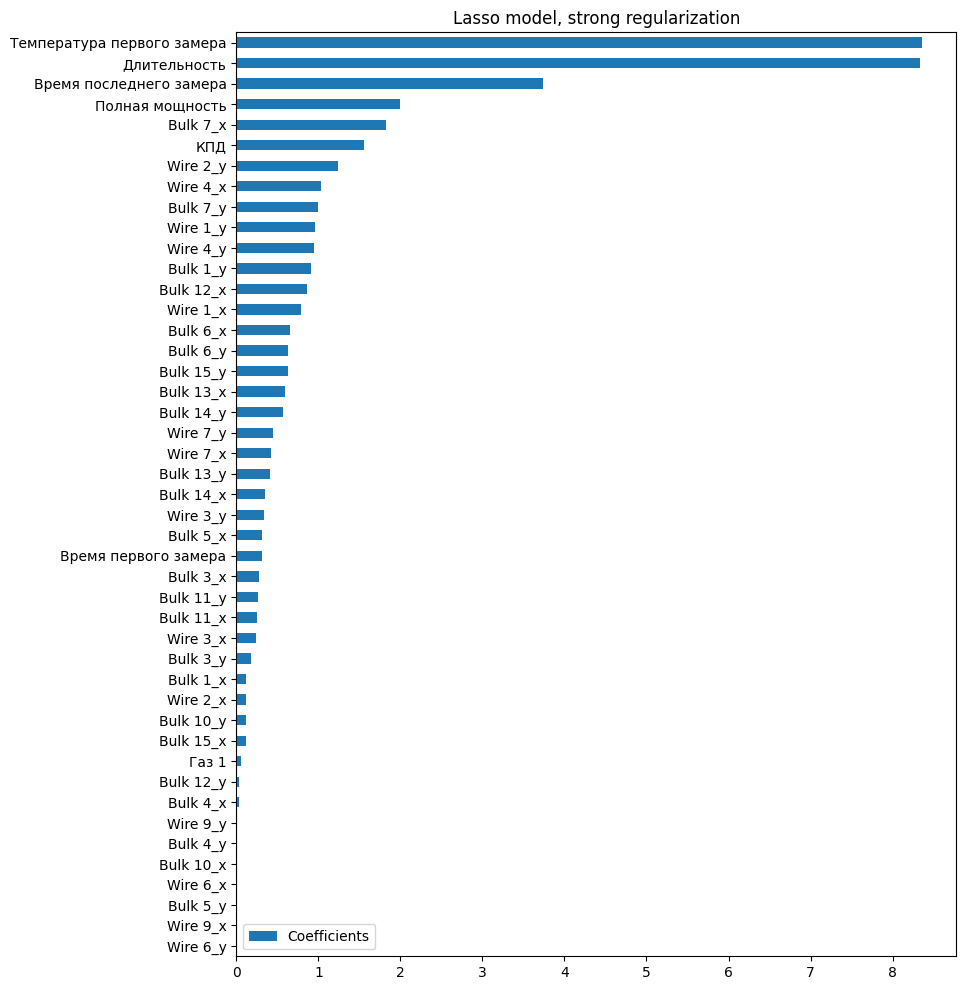

In [348]:
coefs = pd.DataFrame(
   abs(lasso_check[1].coef_),
   columns=['Coefficients'], index=features_train.columns
)

coefs.sort_values(by='Coefficients').plot(kind='barh', figsize=(12, 12))
plt.title('Lasso model, strong regularization')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

Наибольшее влияние на модель оказывают признаки `Температура первого замера` и `Длительность нагрева`. Также, большой вклад вносит `Время последнего замера`.

### Выводы

Итоговое значение метрики `MAE` на тестовых данных равно 5.6, что полтостью удовлетворяет поставленной задаче. На тренировочных данных модель `LASSO` оказалась лучшей.

## Отчет

### Описание и задача

Проект представляет собой работу с данными металлургического комбината, изучение технологического процесса плавления металалла и оптимизацию затрат. Несмотря на то, что не все данные мы видим в явном виде (некоторые данные зашифрованы, и мы видим лишь порядковый номер, каких-то данных нет вовсе), перед нами стоит задача:

- при имеющихся данных собрать модель предсказаний конечной температуры каждой партии стали. Это необходимо для оптимизации производственных расходов комбинатата - уменьшения затрат на электроэнергию на этапе обработки стали.

Для измерения качества предсказания взята метрика `MAE` - средняя абсолютная ошибка. Чем меньше ее значение в результате машинного обучения - тем лучше модель, дающая предсказания.

Достаточной метрикой принимается значение `MAE`, равное 6.8. Является задачей регрессии.

Все поставленные в плане задачи к проекту были выполнены. Самой большой трудностью была работа с признаками. Как их подготовить? Какие войдут в итоговый датасет? Какие необходимо создать, а какие удалить?

Все эти вопросы решались последовательно и описаны подробно в проекте, а более сжато - в тексте ниже.

### Исходные данные

Исходные данные делятся на 7 датасетов, связанных между собой номером партии - столбец `key`. Датасеты имеют разное количество столбцов и строк. В двух датасетах номера партии поделены на несколько строк (`data_arc` и `data_temp`), в остальных - каждое значение `key` уникально.

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` — данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

Целевым признаком является конечная температура. В явном виде такого признака нет. Эти данные есть в `data_temp`, в последних записях каждого ключа. Этот целевой признак необходимо выделить в отдельный столбец.

Также, ключевым моментом являются выбросы: критичные значения величин, которые точно необходимо убрать перед началом обучения такие:

- мощность должна быть неотрицательной,
- температура не должна быть ниже 1500 градусов. Важно также отметить, что это правило распространяется в отношении всей партии, если было значение ниже, то из обучения убирается вся партия.

Еще одно из основных условий: партии, не имеющие конечной температуры в наборе данных, также удаляются. Это логичное требование, т.к. этот прижнак является целевым.

### Работа с данными (раздельные датасеты)

Практически каждый из датасетов претерпел изменения в процессе предобработки данных. Рассмотрим это подробнее:

Датасет `data_arc`:

- Удалены выбросы (партия, имеющая в данных отрицательную мощность).

- Созданы новые, более информативные признаки: `Полная мощность` и `КПД`.

- Для данных о времени изменен тип и найдена `Длительнось` нагрева электродами. Вынесена в новый признак. Также создан вспомогательный признак `Старт` для дальнейшей работы с датами в других датасетах после слияния.

- Удалены менее информативные признаки `Активная мощность` и `Реактивная мощность`, а также `Конец нагрева дугой`.

- Данные сгруппированы по партиям. Агрегация для параметров:

    - `Полная мощность` и `КПД` - среднее значение для партии,
    
    - `Длительнось` - суммарное время для партии.

Датасеты `data_bulk` и `data_wire`:

- Пропуски заполнены нулями. Т.к. данные этих датасетов - добавление сыпучих материалов или проволоки соответственно.

Датасеты `data_bulk_time` и `data_wire_time`:

- Чтобы достать признаки из дат и работать с ними, для данных из датасетов изменили тип данных на `datetime`.

Датасет `data_gas`:

- Не требовал обработки данных.

Датасет `data_temp`:

- Имел пропуски в значении температуры, поэтому была добавлена заглушка - температура, которая точно не встретилась бы в расплавленном металле, например, отрицательная.

- Данные были сгруппированы по ключу и данным температуры, найдены значения конечных температур каждой партии и составлен список с номерами партии, где значение конечной температуры было равно заглушке. Такие ключи (и данные в них) были удалены из датасета.

- Удалены данные ключей, для которых была зафиксирована температура ниже 1500 градусов.

- Данные о времени приведены к нужному типу. `Время первого замера` и `Время последнего замера` выделены в новые столбцы для дальнейшей работы с ними, как с признаками. Удален столбец `Время замера`. 

- То же самое проделано с данными о температуре. Выделены новые признаки `Температура первого замера` и `Температура целевая`, но удален столбец `Температура`.  На этом этапе мы получили целевой признак.

- Данные сгруппированы по партиям по первой записи (из-за особенности полученного датасета).



### Работа с данными (слияние в один датасет)

- Слияние датасетов `data_arc` и `data_bulk_time` по ключу методом `.merge()` и присвоение ему нового имени `df`.

    - Заполнение пропусков (которые оставались в датасете `data_bulk_time`) датой `Старта`. Далее, перезаписываем время добавления материала как разность между этим временем и временем `Старта` в секундах. Таким образом получаем новые признаки с плавающей точкой, где, если присадка не была добавлена, значение нового признака будет равно нулю.

- Слияние датасетов `df` и `data_bulk`, аналогично предыдущему (ключ и метод для всех слияний одинаков, здесь и далее) с перезаписью датасета `df`.

- Слияние датасетов `df` и `data_wire_time`.

    - Заполнение пропусков аналогично предыдущему. Создание признаков - аналогично. Логическое обоснование - аналогично.

- Слияние датасетов `df` и `data_wire`.

- Слияние датасетов `df` и `data_gas`.

- Слияние датасетов `df` и `data_temp`.

    - Создание новых признаков: `Время последнего замера` как разность `времени последнего` и `первого замеров` - время между замерами; `Время первого замера` как разность между `временем первого замера` и временем `старта`.
    
    - Удаление времени `старта`.

Проверяем на мультиколлинеарность и удаляем признаки, которые между собой имеют большой коэффициент инфляции дисперсии (либо, как в случае с двуся столбцами, имеют значение `NaN`). Эти признаки имели от одного до одного десятка значений, отличных от нуля, поэтому их удаление не исказит реальную картину при обучении.

После этапа предобработки имеем один датасет, размером 2324 строк на 46 признаков + 1 целевой признак. Пропусков не имеется. Все ключи `key` уникальны. Все признаки типа `float64`.

### Обучение

Датасет делим на четыре датасета:

- `features_train` - тренировочный датасет признаков,
- `features_test` - тестовый датасет признаков,
- `target_train` - тренировочный целевой признак,
- `target_test` - тестовый целевой признак.

Выборки делятся в соотношении 75% к 25% (`train` к `test`) и с опорным числом рандома `random_state`, равным 100423.

Вводим "глупую" модель, предсказывающую среднее значение температуры для вывода, очевидно, плохой метрики `MAE`, для того, чтобы можно было ориентироваться на это значение (получить не хуже на реальных моделях). Значение метрики `MAE` такой модели равно 8.26.

Первая модель - модель линейной регрессии. Модель рассматриваем без перебора параметров, как базовую модель регрессии, работающую быстро и дающую вменяемые результаты. Кросс-валидация используется во всех моделях обучения. Результаты, которые показывает линейная регрессия: `MAE` 5.73, это значение уже в таком виде удовлетворяет условию задачи.

Модель `LASSO` с перебором гиперпараметров и с использованием пайплайна (во избежание утечки, т.к. данные для этой модели стандартизируются) показывает значение метрики `MAE`, равное 5.71. Самый лучший результат. Все последующие модели показывают более высокое значение метрики.

Модель случайного леса с перебором гиперпараметров показывает значение `MAE` 5.91 (значение всегда варьируется, т.к. модель использует `RandomizedSearchCV` в качестве перебора гиперпараметров).

Модель с градиентным бустингом `LightGBM` имеет значение `MAE` 5.7 (аналогично модели случайного леса, может варьироваться).

### Результат

Лучшей моделью на тренировочных данных стала модель `LASSO`, дав значение метрики `MAE`, равное 5.71.

- значение регуляризации `alfa` равном 0.05, 
- максимальное количество итераций `max_iter` = 1000,
- `cv` = 200.

Обучив эту модель на тренировочных данных и предсказав тестовые, мы получили значение метрики `MAE`, равное 5.6, полностью выполнив поставленную задачу.